In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# colab으로 visdom사용하는 법을 알아내지 못해 실행은 못했습니다.
import visdom

vis = visdom.Visdom()
vis.close(env="main")

ModuleNotFoundError: ignored

In [5]:
# define value tracker
def value_tracker(value_plot, value, num):
    '''num, loss_value, are Tensor'''
    plt.plot(X=num, Y=value, win = value_plot, update='append')

In [6]:
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
print(trainset.data.shape)

train_data_mean = trainset.data.mean(axis=(0,1,2))
train_data_std = trainset.data.std(axis=(0,1,2))

print(train_data_mean)
print(train_data_std)

train_data_mean = train_data_mean / 255
train_data_std = train_data_std / 255

print(train_data_mean)
print(train_data_std)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
(50000, 32, 32, 3)
[125.30691805 122.95039414 113.86538318]
[62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
import torchvision.models.resnet as resnet

In [10]:
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [11]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [12]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 10, True).to(device) 

In [13]:
resnet50

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [14]:
a=torch.Tensor(1,3,32,32).to(device)
out = resnet50(a)
print(out)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [15]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr = 0.1, momentum = 0.9, weight_decay=5e-4)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

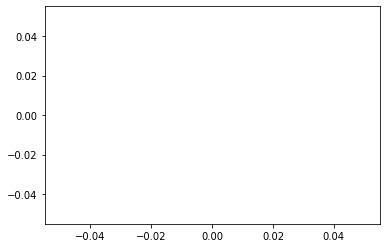

In [16]:
# colab으로 visdom사용하는 법을 알아내지 못해 visdom으로 실행은 못했습니다.
# plot
loss_plt = plt.plot(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))
acc_plt = plt.plot(Y=torch.Tensor(1).zero_(),opts=dict(title='Accuracy', legend=['Acc'], showlegend=True))

In [17]:
# define acc_check function
def acc_check(net, test_set, epoch):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy of the network on the 10000 test images: %d %%' % acc)
    return acc

In [ ]:
# train
print(len(trainloader))
epochs = 50

for epoch in range(epochs):

    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
    
    #Check Accuracy
    acc = acc_check(resnet50, testloader, epoch)
    value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    

print('Finished Training')

196


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,    30] loss: 2.060
[1,    60] loss: 1.892
[1,    90] loss: 1.794
[1,   120] loss: 1.708
[1,   150] loss: 1.670
[1,   180] loss: 1.566
Accuracy of the network on the 10000 test images: 40 %
[2,    30] loss: 1.492
[2,    60] loss: 1.436
[2,    90] loss: 1.390
[2,   120] loss: 1.376
[2,   150] loss: 1.277
[2,   180] loss: 1.241
Accuracy of the network on the 10000 test images: 49 %
[3,    30] loss: 1.185
[3,    60] loss: 1.167
[3,    90] loss: 1.119
[3,   120] loss: 1.093
[3,   150] loss: 1.053
[3,   180] loss: 1.018
Accuracy of the network on the 10000 test images: 58 %
[4,    30] loss: 1.005
[4,    60] loss: 0.985
[4,    90] loss: 0.971
[4,   120] loss: 0.963
[4,   150] loss: 0.956
[4,   180] loss: 0.918
Accuracy of the network on the 10000 test images: 62 %
[5,    30] loss: 0.862
[5,    60] loss: 0.849
[5,    90] loss: 0.850
[5,   120] loss: 0.842
[5,   150] loss: 0.825
[5,   180] loss: 0.801
Accuracy of the network on the 10000 test images: 67 %
[6,    30] loss: 0.769
[6,    60] l

In [18]:
# test
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %
